# Pill Identification System Test

This notebook demonstrates:
1. **Image Search**: Find similar pills using CLIP embeddings and FAISS
2. **FDA Drug Lookup**: Get drug information by NDC code
3. **Complete Pipeline**: Image → Similar Pills → FDA Information

In [1]:
# Import required libraries
import faiss
import numpy as np
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
import requests
from IPython.display import display
import sys
import os

# Add parent directory to path to import fda module
sys.path.insert(0, os.path.abspath('.'))
from fda import get_drug_info

brand_name: Strattera

generic_name: Atomoxetine hydrochloride

dosage_form: CAPSULE

route: ['ORAL']

manufacturer: Eli Lilly and Company

warnings: ['No warnings found']

adverse_reactions: ["6 ADVERSE REACTIONS6.1 Clinical Trials Experience STRATTERA was administered to 5382 children or adolescent patients with ADHD and 1007 adults with ADHD in clinical studies. During the ADHD clinical trials, 1625 children and adolescent patients were treated for longer than 1 year and 2529 children and adolescent patients were treated for over 6 months. Because clinical trials are conducted under widely varying conditions, adverse reaction rates observed in the clinical trials of a drug cannot be directly compared to rates in the clinical trials of another drug and may not reflect the rates observed in practice. Child and Adolescent Clinical Trials Reasons for discontinuation of treatment due to adverse reactions in child and adolescent clinical trials — In acute child and adolescent placebo-cont

## Step 1: Load FAISS Index and CLIP Model

In [2]:
# Configuration
INDEX_FILE = "../../vectorstore/pill_images.faiss"
METADATA_FILE = "../../vectorstore/pill_metadata.npy"
EMBEDDING_MODEL = "openai/clip-vit-base-patch32"

# Load FAISS index and metadata
print(f"Loading FAISS index from {INDEX_FILE}...")
index = faiss.read_index(INDEX_FILE)
metadata = np.load(METADATA_FILE, allow_pickle=True)
print(f"✓ Loaded {index.ntotal} pill embeddings")

# Load CLIP model
print(f"\nLoading CLIP model: {EMBEDDING_MODEL}...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained(EMBEDDING_MODEL).to(device)
processor = CLIPProcessor.from_pretrained(EMBEDDING_MODEL)
print(f"✓ Model loaded on {device}!")

Loading FAISS index from ../../vectorstore/pill_images.faiss...
✓ Loaded 25996 pill embeddings

Loading CLIP model: openai/clip-vit-base-patch32...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


✓ Model loaded on cpu!


## Test 1: Search Similar Pills by Image

Searching for similar pills to: ../../data/pill.jpg



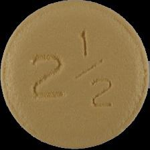


Top 3 Similar Pills:

1. NDC: 0003-0893
   File: 0003-0893_0_1.jpg
   Similarity Distance: 0.0000
   Image: ../../data/archive/ePillID_data/classification_data/segmented_nih_pills_224/0003-0893_0_1.jpg

   FDA Drug Information:
   Brand Name: ELIQUIS
   Generic Name: apixaban
   Manufacturer: E.R. Squibb & Sons, L.L.C.
   Dosage Form: TABLET, FILM COATED
   Route: ['ORAL']
   Warnings: No warnings found...

   Matched Pill Image:


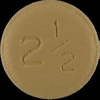


2. NDC: 50090-1436
   File: 50090-1436_0_1.jpg
   Similarity Distance: 0.0000
   Image: ../../data/archive/ePillID_data/classification_data/segmented_nih_pills_224/50090-1436_0_1.jpg

   FDA Drug Information:
   Brand Name: ELIQUIS
   Generic Name: apixaban
   Manufacturer: A-S Medication Solutions
   Dosage Form: TABLET, FILM COATED
   Route: ['ORAL']
   Warnings: No warnings found...

   Matched Pill Image:


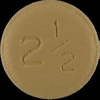


3. NDC: 55154-0612
   File: 55154-0612_0_1.jpg
   Similarity Distance: 0.0000
   Image: ../../data/archive/ePillID_data/classification_data/segmented_nih_pills_224/55154-0612_0_1.jpg

   FDA Drug Information:
   Brand Name: ELIQUIS
   Generic Name: apixaban
   Manufacturer: Cardinal Health 107, LLC
   Dosage Form: TABLET, FILM COATED
   Route: ['ORAL']
   Warnings: No warnings found...

   Matched Pill Image:


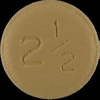

In [3]:
# Query image path
query_img_path = "../../data/pill.jpg"
TOP_K = 3

print(f"Searching for similar pills to: {query_img_path}\n")

# Load and process query image
img = Image.open(query_img_path).convert("RGB")
display(img.resize((150, 150)))  # Display the query image

inputs = processor(images=img, return_tensors="pt").to(device)

with torch.no_grad():
    query_emb = model.get_image_features(**inputs)

query_emb = query_emb.cpu().numpy().astype("float32")

# Search FAISS index
distances, indices = index.search(query_emb, TOP_K)

print(f"\n{'='*70}")
print(f"Top {TOP_K} Similar Pills:")
print(f"{'='*70}\n")

# Base path for pill images
pill_images_base = "../../data/archive/ePillID_data/classification_data/segmented_nih_pills_224"

for rank, (idx, dist) in enumerate(zip(indices[0], distances[0]), 1):
    meta = metadata[idx]
    ndc_raw = meta['ndc']
    # Clean NDC code
    ndc_code = ndc_raw.replace('_0_0.jpg', '').replace('_0_1.jpg', '').replace('.jpg', '')
    
    # Construct full image path
    pill_image_file = meta['file']
    pill_image_path = f"{pill_images_base}/{pill_image_file}"
    
    print(f"{rank}. NDC: {ndc_code}")
    print(f"   File: {meta['file']}")
    print(f"   Similarity Distance: {dist:.4f}")
    print(f"   Image: {pill_image_path}")
    
    # Get FDA info using the utils/fda.py function
    print(f"\n   FDA Drug Information:")
    drug_info = get_drug_info(ndc_code=ndc_code)
    if isinstance(drug_info, str):
        print(f"   {drug_info}")
    else:
        print(f"   Brand Name: {drug_info.get('brand_name', 'N/A')}")
        print(f"   Generic Name: {drug_info.get('generic_name', 'N/A')}")
        print(f"   Manufacturer: {drug_info.get('manufacturer', 'N/A')}")
        print(f"   Dosage Form: {drug_info.get('dosage_form', 'N/A')}")
        print(f"   Route: {drug_info.get('route', 'N/A')}")
        warnings = drug_info.get('warnings', ['N/A'])
        if warnings and warnings[0] != 'N/A':
            print(f"   Warnings: {warnings[0][:500]}...")
    
    # Display the matched pill image
    print("\n   Matched Pill Image:")
    try:
        matched_img = Image.open(pill_image_path).convert("RGB")
        display(matched_img.resize((100, 100)))
    except Exception as e:
        print(f"   Could not load image: {e}")
    
    print()

## Test 2: Direct FDA Lookup by NDC Code

Direct FDA Drug Lookup by NDC Code


NDC: 51285-0092
----------------------------------------------------------------------
Error: No NDC data found for code 51285-0092

Pill Image:
No image found in index for this NDC code


NDC: 00555-0572
----------------------------------------------------------------------
Error: No NDC data found for code 00555-0572

Pill Image:
No image found in index for this NDC code


NDC: 0006-0081
----------------------------------------------------------------------
Brand Name: JANUMET XR
Generic Name: sitagliptin and metformin hydrochloride
Manufacturer: Merck Sharp & Dohme LLC
Dosage Form: TABLET, FILM COATED, EXTENDED RELEASE
Route: ['ORAL']

Warnings: No warnings found...

Adverse Reactions: 6 ADVERSE REACTIONS The following adverse reactions are also discussed elsewhere in the prescribing information: Lactic Acidosis [see Warnings and Precautions ( 5.1 )] Pancreatitis [see Warnings and Precautions ( 5.2 )] Heart Failure [see Warnings and Precautions (

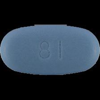

In [4]:
# Test with a known NDC code
test_ndc_codes = [
    "51285-0092",  # Test NDC 1
    "00555-0572",  # Test NDC 2
    "0006-0081"    # Test NDC 3
]

print(f"{'='*70}")
print("Direct FDA Drug Lookup by NDC Code")
print(f"{'='*70}\n")

# Base path for pill images
pill_images_base = "../../data/archive/ePillID_data/classification_data/segmented_nih_pills_224"

for ndc in test_ndc_codes:
    print(f"\nNDC: {ndc}")
    print("-" * 70)
    
    drug_info = get_drug_info(ndc_code=ndc)
    
    if isinstance(drug_info, str):
        print(f"Error: {drug_info}")
    else:
        print(f"Brand Name: {drug_info.get('brand_name', 'N/A')}")
        print(f"Generic Name: {drug_info.get('generic_name', 'N/A')}")
        print(f"Manufacturer: {drug_info.get('manufacturer', 'N/A')}")
        print(f"Dosage Form: {drug_info.get('dosage_form', 'N/A')}")
        print(f"Route: {drug_info.get('route', 'N/A')}")
        
        warnings = drug_info.get('warnings', ['N/A'])
        if warnings and warnings[0] != 'N/A':
            print(f"\nWarnings: {warnings[0][:300]}...")
        
        adverse = drug_info.get('adverse_reactions', ['N/A'])
        if adverse and adverse[0] != 'N/A':
            print(f"\nAdverse Reactions: {adverse[0][:300]}...")
    
    # Find and display pill image for this NDC
    print("\nPill Image:")
    found_image = False
    for meta in metadata:
        ndc_raw = meta['ndc']
        ndc_code = ndc_raw.replace('_0_0.jpg', '').replace('_0_1.jpg', '').replace('.jpg', '')
        if ndc_code == ndc:
            pill_image_file = meta['file']
            pill_image_path = f"{pill_images_base}/{pill_image_file}"
            print(f"Image Path: {pill_image_path}")
            try:
                pill_img = Image.open(pill_image_path).convert("RGB")
                display(pill_img.resize((100, 100)))
                found_image = True
                break
            except Exception as e:
                print(f"Could not load image: {e}")
    
    if not found_image:
        print("No image found in index for this NDC code")
    
    print()

## Test 3: Complete Pipeline Test

Test the entire workflow: Upload image → Find similar pills → Get FDA information


PILL IDENTIFICATION PIPELINE

Query Image: ../../data/pill.jpg



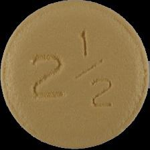


Top 3 Matches:

Match #1
  NDC: 0003-0893
  Similarity: 0.0000
  Drug: ELIQUIS
  Generic: apixaban
  Manufacturer: E.R. Squibb & Sons, L.L.C.
  Dosage Form: TABLET, FILM COATED



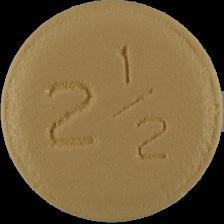


Match #2
  NDC: 50090-1436
  Similarity: 0.0000
  Drug: ELIQUIS
  Generic: apixaban
  Manufacturer: A-S Medication Solutions
  Dosage Form: TABLET, FILM COATED



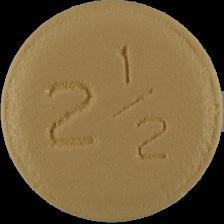


Match #3
  NDC: 55154-0612
  Similarity: 0.0000
  Drug: ELIQUIS
  Generic: apixaban
  Manufacturer: Cardinal Health 107, LLC
  Dosage Form: TABLET, FILM COATED



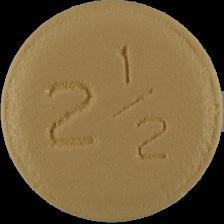



Base64 Image Data Available for Frontend:
  NDC 0003-0893: 8272 chars (first 50: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQ...)
  NDC 50090-1436: 8272 chars (first 50: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQ...)
  NDC 55154-0612: 8272 chars (first 50: /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQ...)


In [5]:
import base64
from IPython.display import HTML

def identify_pill_from_image(image_path: str, top_k: int = 3):
    """
    Complete pipeline: Load image → Find similar pills → Get FDA info
    Returns base64 encoded matched images for frontend display
    """
    print(f"\n{'='*70}")
    print(f"PILL IDENTIFICATION PIPELINE")
    print(f"{'='*70}\n")
    print(f"Query Image: {image_path}\n")
    
    # Load and display image
    img = Image.open(image_path).convert("RGB")
    display(img.resize((150, 150)))
    
    # Get image embedding
    inputs = processor(images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        query_emb = model.get_image_features(**inputs)
    query_emb = query_emb.cpu().numpy().astype("float32")
    
    # Search similar pills
    distances, indices = index.search(query_emb, top_k)
    
    print(f"\n{'='*70}")
    print(f"Top {top_k} Matches:")
    print(f"{'='*70}\n")
    
    # Base path for pill images
    pill_images_base = "../../data/archive/ePillID_data/classification_data/segmented_nih_pills_224"
    
    results = []
    for rank, (idx, dist) in enumerate(zip(indices[0], distances[0]), 1):
        meta = metadata[idx]
        ndc_raw = meta['ndc']
        ndc_code = ndc_raw.replace('_0_0.jpg', '').replace('_0_1.jpg', '').replace('.jpg', '')
        
        # Construct full image path
        pill_image_file = meta['file']
        pill_image_path = f"{pill_images_base}/{pill_image_file}"
        
        print(f"Match #{rank}")
        print(f"  NDC: {ndc_code}")
        print(f"  Similarity: {dist:.4f}")
        
        # Get FDA data using utils/fda.py function
        drug_info = get_drug_info(ndc_code=ndc_code)
        if not isinstance(drug_info, str):
            print(f"  Drug: {drug_info.get('brand_name', 'N/A')}")
            print(f"  Generic: {drug_info.get('generic_name', 'N/A')}")
            print(f"  Manufacturer: {drug_info.get('manufacturer', 'N/A')}")
            print(f"  Dosage Form: {drug_info.get('dosage_form', 'N/A')}")
            
            # Encode image as base64 and display using HTML img tag
            try:
                with open(pill_image_path, "rb") as img_file:
                    image_base64 = base64.b64encode(img_file.read()).decode("utf-8")
                
                # Display using HTML img tag with base64
                html_img = f'<img src="data:image/jpeg;base64,{image_base64}" alt="Matched pill {ndc_code}" style="width:100px;height:100px;border:2px solid #4CAF50;border-radius:8px;" />'
                display(HTML(html_img))
                
                results.append({
                    "ndc": ndc_code,
                    "distance": dist,
                    "image_path": pill_image_path,
                    "image_base64": image_base64,  # Include base64 for frontend
                    "drug_info": drug_info
                })
            except Exception as e:
                print(f"  Could not load image: {e}")
        else:
            print(f"  FDA Info: {drug_info}")
        print()
    
    return results

# Test with sample pill image
test_image = query_img_path
results = identify_pill_from_image(test_image, top_k=3)

# Show the base64 data is available
if results:
    print(f"\n{'='*70}")
    print("Base64 Image Data Available for Frontend:")
    print(f"{'='*70}")
    for r in results:
        b64 = r.get('image_base64', '')
        print(f"  NDC {r['ndc']}: {len(b64)} chars (first 50: {b64[:50]}...)")